### Exercise 1

In [1]:
# import packages important for the execution of this assignment
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import pandas as pd

import numpy as np
import numpy.random as npr
import scipy.stats as scs
np.random.seed(500)

Exercise 1.
Evaluate the option price under Heston model for the following parameters, using a crude Monte-Carlo simulation approach. "Crude" means you don't use any variance reduction technique.

v0 (initial variance) = 0.04;
kappa (mean-reversion rate) = 1.5
theta (long-run average) = 0.02
sigma ( vol-vol for variance process) = 0.15
rho (correlation coeff) = -0.5
r (risk-free rate) =0.05
S0=100.0 
for a strike price  K=90,100,120  (please choose one of the three)
Maturity  T=1.0/12  (i.e. one month)

In [2]:
# set the variables
v0 = 0.04; kappa = 1.5; theta = 0.02; sigma = 0.15; rho = -0.5; r = 0.05; S0 = 100.0;T = 1/12; M = 50; I = 500000

In [3]:
def MCHeston(S0, r, T, sigma, kappa, theta, rho, I, M, BIAS = False):
    corr_mat = np.zeros((2, 2))
    corr_mat[0, :] = [1.0, rho] #make the correlation matrix
    corr_mat[1, :] = [rho, 1.0]
    cho_mat = np.linalg.cholesky(corr_mat) #get the cholesky matrix
    dt = T / M
    t = 1
    ran_num = npr.standard_normal((2, M + 1, I)) 
    v = np.zeros_like(ran_num[0])
    vh = np.zeros_like(v)
    v[0] = v0
    vh[0] = v0
    S = np.zeros_like(ran_num[0])
    S[0] = S0
    for t in range(1, M + 1):
        ran = np.dot(cho_mat, ran_num[:, t, :])
        #this scheme is called full-truncation
        vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt
          + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt)  
          * ran[1])
        v[t] = np.maximum(0, vh[t])
        
        # make the bias if statement here and calculate the coresponding S if the parameter in the function is True
        if BIAS == True:
            bias = np.mean(np.sqrt(v[t])*ran[0]*np.sqrt(dt))
            S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt) - bias)
        else:
            S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt))
    # here this is for priting purposes
    call = np.zeros(3) #make an array of index 3 filled with zeros in order to fill it in with our values
    put = np.zeros(3)
    K = [80.0,100.0,120.0]
    for i in range(3):
        call[i] = np.exp(-r*T)*np.mean(np.maximum(S[-1] - K[i],0))
        put[i] = np.exp(-r*T)*np.mean(np.maximum(K[i] - S[-1],0))

        print('Call equals: ', call[i], ' Put equals: ',  put[i], ' with strike ', K[i]) #print the call and put with the corresponding strike

In [7]:
MCHeston(S0, r, T, sigma, kappa, theta, rho, I, M, BIAS=True)

Call equals:  20.33286542169472  Put equals:  0.00021447131385741343  with strike  80.0
Call equals:  2.4740414319462745  Put equals:  2.0582305184676093  with strike  100.0
Call equals:  0.0005955936386420905  Put equals:  19.501624717062178  with strike  120.0


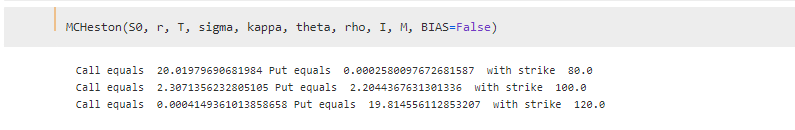 
The above image indicates the results when you use the BIAS as false.

## Homework 8
Get data from web and do portfolio minimization tasks on a set of stocks of your choice.

Describe your optimal portfolio explictly. Write down the weights, expected portfolio return, standard deviation of the portfolio return and the Sharpe ratio.

Hope you get a portfolio with better Sharpe ratio, preferabbly a value higher than one. The portfolio used in this lecture is simply for demonstration purpose, it is not necessarily the best-diversified portfolio.

However, if you change the end date of the data collection to sometime before the pandemic, re-run the optimization, you will get a higher Shape ratio.

In [5]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import scipy.optimize as sco  # need an optimizer here
#get the data of Pfizer, Nexflix, ABB, Astra Zeneca and Meta
symbols= ['PFE','NFLX','ABB', 'AZN', 'META' ]
data = web.DataReader(symbols,'yahoo', start="2012-11-16", end="2022-11-23")['Adj Close']
data.dropna() #drop the NaN values (in case there are some)
data.reset_index() # reset the index

Symbols,Date,PFE,NFLX,ABB,AZN,META
0,2012-11-16,15.826694,11.557143,12.484469,15.084775,23.559999
1,2012-11-19,16.012424,11.622857,12.738534,15.254884,22.920000
2,2012-11-20,16.105284,11.771429,12.703249,15.346736,23.100000
3,2012-11-21,16.151714,11.857143,12.900856,15.431788,24.320000
4,2012-11-23,16.271111,11.850000,13.274894,15.806013,24.000000
...,...,...,...,...,...,...
2518,2022-11-17,48.330002,295.279999,30.490000,64.059998,111.449997
2519,2022-11-18,48.230000,287.980011,30.719999,65.070000,112.050003
2520,2022-11-21,48.180000,285.049988,30.680000,65.430000,109.860001
2521,2022-11-22,49.080002,286.690002,31.150000,66.000000,111.440002


In [6]:
# daily returns including index
retsAsset = np.log(data / data.shift(1)) #calculate the returns for each asset
# noa is number of asset
noa = len(symbols) 

dailyCov = retsAsset.cov() #get the daily covariance
# covariances of the returns for the assets
covMatrix = dailyCov * 252 #
covMatrix

Symbols,PFE,NFLX,ABB,AZN,META
Symbols,,,,,
PFE,0.047711,0.017813,0.018099,0.021677,0.020040
NFLX,0.017813,0.226844,0.030869,0.024323,0.074816
ABB,0.018099,0.030869,0.056441,0.020381,0.031860
AZN,0.021677,0.024323,0.020381,0.061144,0.023768
META,0.020040,0.074816,0.031860,0.023768,0.147523


In [7]:
def portfolio_stats(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        volatility of portfolio return
    pret / pvol : float
        Sharpe ratio, assuming risk free-rate rf=0
    '''
    weights = np.array(weights) #make an array 
    pret = np.sum(retsAsset.mean() * weights) * 252 #calculate the portfolio returns
    pvol = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) #portfolio volatility
    return np.array([pret, pvol, pret / pvol]) #return the return, volatility, sharpe ratio

In [8]:
 def min_func_sharpe(weights):
    return -portfolio_stats(weights)[2] #here we maximize the sharpe ratio

In [9]:
constraint = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # a tuple of dict
# tuple comprehension, must use tuple(       )
bounds = tuple((0, 1) for x in range(noa))
bounds #bounds for the 5 assets

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [10]:
equallyWeights= np.ones(noa)*(1./noa)
equallyWeights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [11]:
opts = sco.minimize(min_func_sharpe, equallyWeights, method='SLSQP',
                       bounds=bounds, constraints=constraint)
opts

     fun: -0.8593660524437869
     jac: array([-3.67045403e-04, -3.37526202e-04,  7.56680965e-05,  5.61334193e-04,
       -2.23062932e-04])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.30574672, 0.28784099, 0.01246957, 0.37775372, 0.016189  ])

In [12]:
# optimization yields a portfolio of only three out of five assets
print('Weights for portfolio with highest Sharpe Ratio', opts['x'].round(3)) 

Weights for portfolio with highest Sharpe Ratio [0.306 0.288 0.012 0.378 0.016]


In [13]:
print('The return, volatility, and Sharpe-Ratio are:', portfolio_stats(opts['x']).round(3))

The return, volatility, and Sharpe-Ratio are: [0.187 0.217 0.859]


In [14]:
# objective function if you want to minimize variance
def min_func_variance(weights):
    return portfolio_stats(weights)[1] ** 2

optv = sco.minimize(min_func_variance, equallyWeights, method='SLSQP',
                       bounds=bounds, constraints=constraint)
optv

     fun: 0.030867114415310964
     jac: array([0.0616862 , 0.06183408, 0.06192069, 0.06159052, 0.06160272])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.39946175, 0.02613231, 0.29879846, 0.23705885, 0.03854863])

In [15]:
print('Weights for the optimal portfolio',optv['x'].round(3))

Weights for the optimal portfolio [0.399 0.026 0.299 0.237 0.039]


In [16]:
print('Optimal Portfolio: the return, volatility, standard deviation and Sharpe-Ratio are:', portfolio_stats(optv['x']).round(3))

Optimal Portfolio: the return, volatility, standard deviation and Sharpe-Ratio are: [0.122 0.176 0.694]


Sharpe-Ratio here is basically low as I took into consideration the period of the pandemic. When I re-ran the code with the same starting period to 2019-01-01 I got: 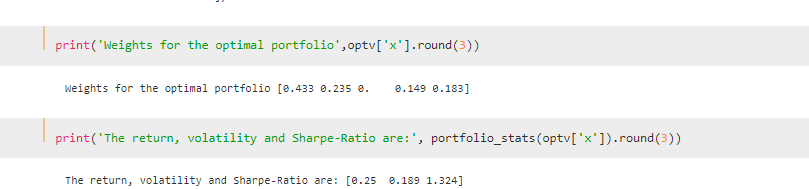 which basically is what we wanted to see a Sharpe Ratio over 1 since portfolios with sharpe ratio over 1 usually offering excess returns relative to volatility.

### Continuation of exercise above

In [17]:
def min_func_port(weights):
    return portfolio_stats(weights)[1]

trets = np.linspace(0.0,0.18,50) # the target returns
tvols = [] # volatility
for tret in trets: 
    #print(tret)
    #print('The minimum vol is', opts['fun'])
    cons = ({'type': 'eq', 'fun': lambda x:  portfolio_stats(x)[0] - tret}, #make the constraints as they were given in the lectures
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, equallyWeights, method='SLSQP',bounds=bounds, constraints=cons) #here basically is the same as in the exercise 8 but I had some problems with applying the two constraints
    # to the exercise's 8 code
    tvols.append(res['fun']) #the value of the objective, i.e. standard deviation
tvols = np.array(tvols)

In [18]:
df= pd.DataFrame([trets, tvols]).T
df.columns =['Target Return', 'Vol']
df['Vol'].idxmin()

33

In [19]:
#Returns the indices of the minimum values 
ind = np.argmin(tvols)
print(ind)

# take away the lower part of curve to the efficient frontier
evols = tvols[ind:]
erets = trets[ind:]
print(evols)
erets

33
[0.17569765 0.17577744 0.17615843 0.17683527 0.17780718 0.17906954
 0.18061539 0.18243738 0.18452748 0.18687737 0.18947617 0.19231516
 0.19538261 0.19866889 0.20216301 0.20585431 0.20973241]


array([0.12122449, 0.12489796, 0.12857143, 0.1322449 , 0.13591837,
       0.13959184, 0.14326531, 0.14693878, 0.15061224, 0.15428571,
       0.15795918, 0.16163265, 0.16530612, 0.16897959, 0.17265306,
       0.17632653, 0.18      ])

In [20]:
# prepare lists for portfolio returns and volatilities
prets = []
pvols = []
# randomly generate 5000 portfolios
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
        
    # portfolio return
    prets.append(np.sum(retsAsset.mean() * weights) * 252)
    #portfolio volatility
    pvols.append(np.sqrt(np.dot(weights, 
                        np.dot(retsAsset.cov() * 252, weights.T))))
prets = np.array(prets)
pvols = np.array(pvols)

Text(0.5, 1.0, 'Minimum risk portfolios for given return level (crosses)')

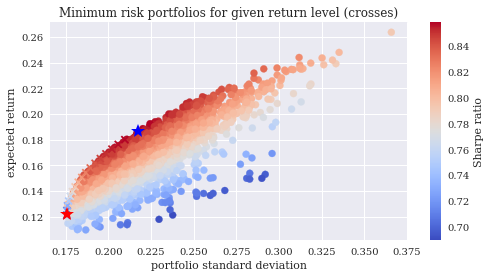

In [21]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=plt.cm.coolwarm )
            # random portfolio composition
plt.scatter(evols, erets, c = erets/evols,marker='x', cmap=plt.cm.coolwarm)
            # efficient frontier
plt.plot(portfolio_stats(opts['x'])[1], portfolio_stats(opts['x'])[0],
         'b*', markersize=15.0)
            # the sharpe ratio of the portfolio
plt.plot(portfolio_stats(optv['x'])[1], portfolio_stats(optv['x'])[0],
         'r*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('portfolio standard deviation')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.title('Minimum risk portfolios for given return level (crosses)')
# here the capital market line must be tangent to the portfolio with the blue star
# in the next photo where I plot the capital market line but I think it is not fully optimized for some reason
# in case Ying you can find where I am mistaken I would be glad to fix it 
# However for me after a lot of tests I did not manage to find out why
# the methodology of plotting is the same as the one you used I just fixed it like that to see
# if it was slightly different in terms of the plot

In [22]:
import scipy.interpolate as sci
risk_free = 0.01

In [23]:
tck = sci.splrep(evols, erets)
print(tck)

(array([0.17569765, 0.17569765, 0.17569765, 0.17569765, 0.17615843,
       0.17683527, 0.17780718, 0.17906954, 0.18061539, 0.18243738,
       0.18452748, 0.18687737, 0.18947617, 0.19231516, 0.19538261,
       0.19866889, 0.20216301, 0.20973241, 0.20973241, 0.20973241,
       0.20973241]), array([0.12122449, 0.12990072, 0.12686626, 0.13399884, 0.13591811,
       0.14012481, 0.14350286, 0.14720721, 0.15081919, 0.15447083,
       0.15812021, 0.16177396, 0.16543222, 0.16909176, 0.17410955,
       0.17766278, 0.18      , 0.        , 0.        , 0.        ,
       0.        ]), 3)


In [24]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

In [25]:
def equations(p, rf=0.001):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3
opt = sco.fsolve(equations, [0.001,0.5,0.18])
opt
# here the warning is unavoidable as this is the only way of making the capital market line 
# to come almost tangent the portfolio with the sharpe ratio portfolio. In general as I read through the material
# of this fsolve they say that it is kinda buggy when you try to use different numbers. Usually you have to put first
# the interest rate, then half of the expected returns and half of the vol.
# However this does not work with my data so well. 
# In case you find any problem feel free to give me feedback and I will try to fix it and re upload again

C:\Users\nicko\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.001     , 0.86125554, 0.22291253])

In [26]:
# check if the solution solves the system

#check eq 2
print(opt[0]+opt[1]*opt[2])
print(f(opt[2]))

#check eq 3
print('Derivative of efficient frontier at tangent point:', df(opt[2]))
np.round(equations(opt), 6)

0.1929846548725261
0.1916400473916724
Derivative of efficient frontier at tangent point: 0.8615554209167966


array([ 0.      ,  0.001345, -0.0003  ])

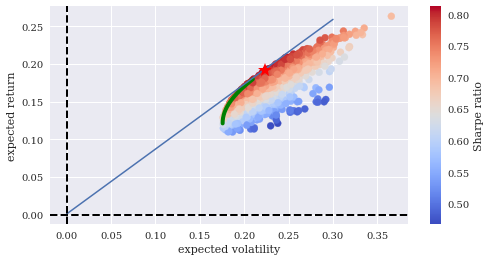

In [27]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o', cmap=plt.cm.coolwarm)
            # random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0)
            # efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Exercise 4
Choose one of the following alternatives:

Alternative 1

Do intepolation and curve fitting to the following data sets.

Suppose the total number of cases are reported at day 0, 1, 2, 7, 8, 9, 14, 15, 16, but not for day 3, 4, 5, 6, 10, 11, 12, 13.

- Using any interpolation kind of your choice, fill in values for reported cases for the missing days. 
- After interpolation, fit a approximation function (of your choice) to the data set. You may try with linear growth or exponential growth.


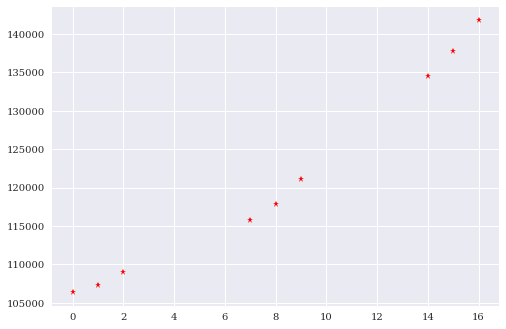

In [28]:
# data for alternative one
# np.nan for the missing data
a = pd.Series([106380,107355,108969,np.nan,np.nan,np.nan,np.nan,
                           115785,117913,121167,np.nan,np.nan,np.nan,np.nan,134532,137730,141764])
day_given = [0, 1, 2, 7, 8, 9, 14, 15, 16]
day_missing = [3,4,5,6,10,11,12,13]
cases_given = [106380, 107355, 108969, 115785, 117913, 121167, 134532, 137730,
       141764]
plt.plot(day_given, cases_given, 'r*')
# plot the given days


In [37]:
interpolate = a.interpolate().copy() #use the interpolate in build function that gives a nice and smooth result
# which by default is calling the "linear" interpolation

In [30]:
interpolate #this is how the data looks


0     106380.0
1     107355.0
2     108969.0
3     110332.2
4     111695.4
5     113058.6
6     114421.8
7     115785.0
8     117913.0
9     121167.0
10    123840.0
11    126513.0
12    129186.0
13    131859.0
14    134532.0
15    137730.0
16    141764.0
dtype: float64

Text(0.5, 1.0, 'Linear interpolation of missing cases by using pandas interpolate()')

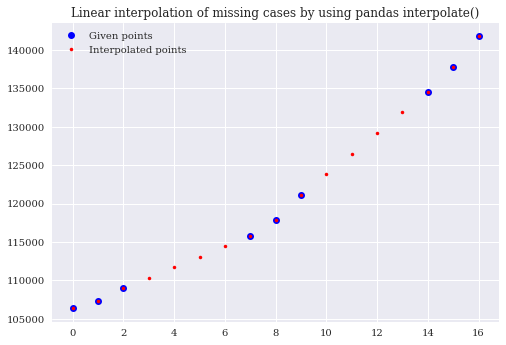

In [31]:
plt.plot(day_given, cases_given, 'bo', label='Given points')
plt.plot(interpolate, 'r.', label='Interpolated points')
plt.legend(loc=0)
plt.title('Linear interpolation of missing cases by using pandas interpolate()')
# plot the missing and given points

In [32]:
data = interpolate[0:17] #use another variable called data

In [33]:
xaxis = range(len(data.index))
print(xaxis)
coefficients = np.polyfit(xaxis,data,2)
print(coefficients) #take the range of the data and use np.polyfit to fit a polynomial

range(0, 17)
[8.40323787e+01 8.39925568e+02 1.06621099e+05]


In [34]:
f = np.poly1d(coefficients) #here this gives back a function with our coefficients 

In [35]:
print(np.poly1d(coefficients))

       2
84.03 x + 839.9 x + 1.066e+05


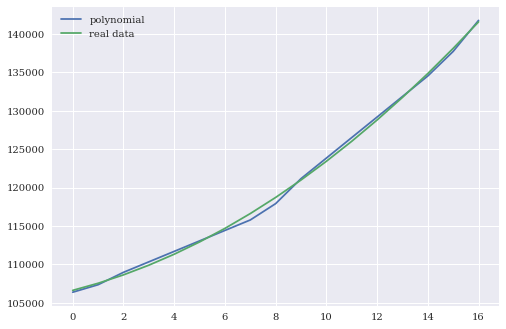

In [36]:
fig, ax = plt.subplots()
plt.plot(xaxis, data)
plt.plot(xaxis,f(xaxis))
ax.legend(['polynomial','real data']) #plot the real data and the fitting curve